## Modelling

Given that my target variable is binary, I can only use classification models. And the limited available time means that I couldn't simply try every model, and to make some decisions as to which models should be excluded.

In the EDA section we saw that there was no clear separation between the two labels, meaning that models such as <code>LogisticRegression</code>, and its regularised derivatives, won't be very useful. Trying to optimise such models would be time consuming but also fruitless.

This lack of separation also means some other models should, in theory, perform better. Based on these assumptions, I decided to experiment with two different models: <code>KNeighborsClassifier</code> and <code>DecisionTreeClassifier</code>.

Also, as we saw during EDA, the major imbalance between the two labels should be accounted for. To do this, I will integrate a <code>RandomOverSampler</code> in my modelling by using pipelines accordingly.

In [1]:
#importing the necessary python libraries
import pandas as pd
import numpy as np
import joblib as jl
from scipy import sparse
import graphviz

import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [2]:
#importing the necessary python libraries
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline

In [3]:
#loading the csvfile containing the complete data
all_features = pd.read_csv('/home/sennaista/Documents/DS/data-resources/capstone-data/airport-weather-agg.csv',
                                  infer_datetime_format=True)

#converting the time column into pandas datetime
all_features['time'] = pd.to_datetime(all_features['time'])

##creatin a binary variable to act as target variable indicating whether a flight was delayed or not
all_features['dep_15_del'] = all_features['dep_delay'].apply(lambda x: 1 if x>15 else 0)

#extracting month, day, day of week and hour information from each observation's timestamp
#to act as further predictors
all_features['month'] = all_features['time'].dt.month
all_features['day'] = all_features['time'].dt.day
all_features['day_of_week'] = all_features['time'].dt.weekday
all_features['hour'] = all_features['time'].dt.hour

In [4]:
#creating a random sample from the data
sample_obs = all_features.sample(frac=0.01, random_state=1)

#creating the predictor dataframe
X = sample_obs[['origin', 'carrier', 'precipitation', 'condition', 'cloud_base', 'dew_temp', 'pressure',
                   'air_temp', 'visibility', 'wind_speed', 'wind_direction', 'month', 'day', 'day_of_week', 'hour']]

#putting the target variable aside
y = sample_obs['dep_15_del']

#dummifying the categorical variables
X_dum = pd.get_dummies(X, columns=['carrier', 'condition', 'origin', 'wind_direction',
                                        'month', 'day', 'day_of_week', 'hour'], drop_first=True)

#creating intraction features between origin and wind direction data
for origin in X_dum.columns[45:64]:
    for wind_direction in X_dum.columns[64:71]:
        column_name = origin+'_'+wind_direction
        X_dum[column_name] = X_dum[origin] * X_dum[wind_direction]

In [5]:
#splitting the data into separate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, train_size=0.7, random_state=1, stratify=y)

#instantiating a StandardScaler and scaling the train and test predictors
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

#### DecisionTreeClassifier

In [6]:
#setting up a pipelie to account for the present imbalance in the target variable before fitting the model
pipe_dt = make_pipeline(RandomOverSampler(random_state=1),
                       (DecisionTreeClassifier(random_state=1)))

#defining the possible values for hyper-parameter optimisation
pipe_dt_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                  'decisiontreeclassifier__max_depth': [5, 10, None],
                  'decisiontreeclassifier__min_samples_split': [2, 5, 9],
                  'decisiontreeclassifier__max_features': [0.3, 0.6]}

#instantiating a GridSearchCV to carry out the optimisation
pipe_dt_gs = GridSearchCV(pipe_dt, pipe_dt_params, cv=5, n_jobs=-3, verbose=1, scoring='recall')
pipe_dt_gs.fit(X_train, y_train)

#printing out the cross-validated score
print('Mean cross-validated score:', pipe_dt_gs.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mean cross-validated score: 0.7099982204682787


In [7]:
#saving the model to file for future use
jl.dump(pipe_dt_gs, 'DecesionTreeClassifier.jlib')

['DecesionTreeClassifier.jlib']

In [8]:
#printing out the optimised hyper-parameters
pipe_dt_gs.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 5,
 'decisiontreeclassifier__max_features': 0.6,
 'decisiontreeclassifier__min_samples_split': 9}

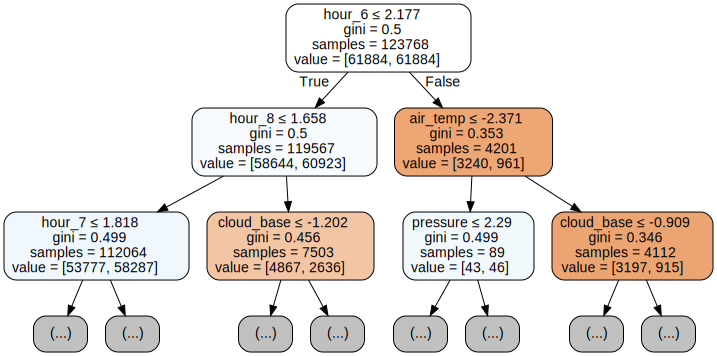

In [9]:
#partially visualising the fitted model
dt_plot = export_graphviz(pipe_dt_gs.best_estimator_[1],
                          max_depth=2,
                          filled=True,
                          rounded=True,
                          special_characters=True,
                          feature_names=X_train.columns)

graph = graphviz.Source(dt_plot)
graph

In [10]:
#making predictions on the test set
dt_predictions = pipe_dt_gs.predict(X_test)

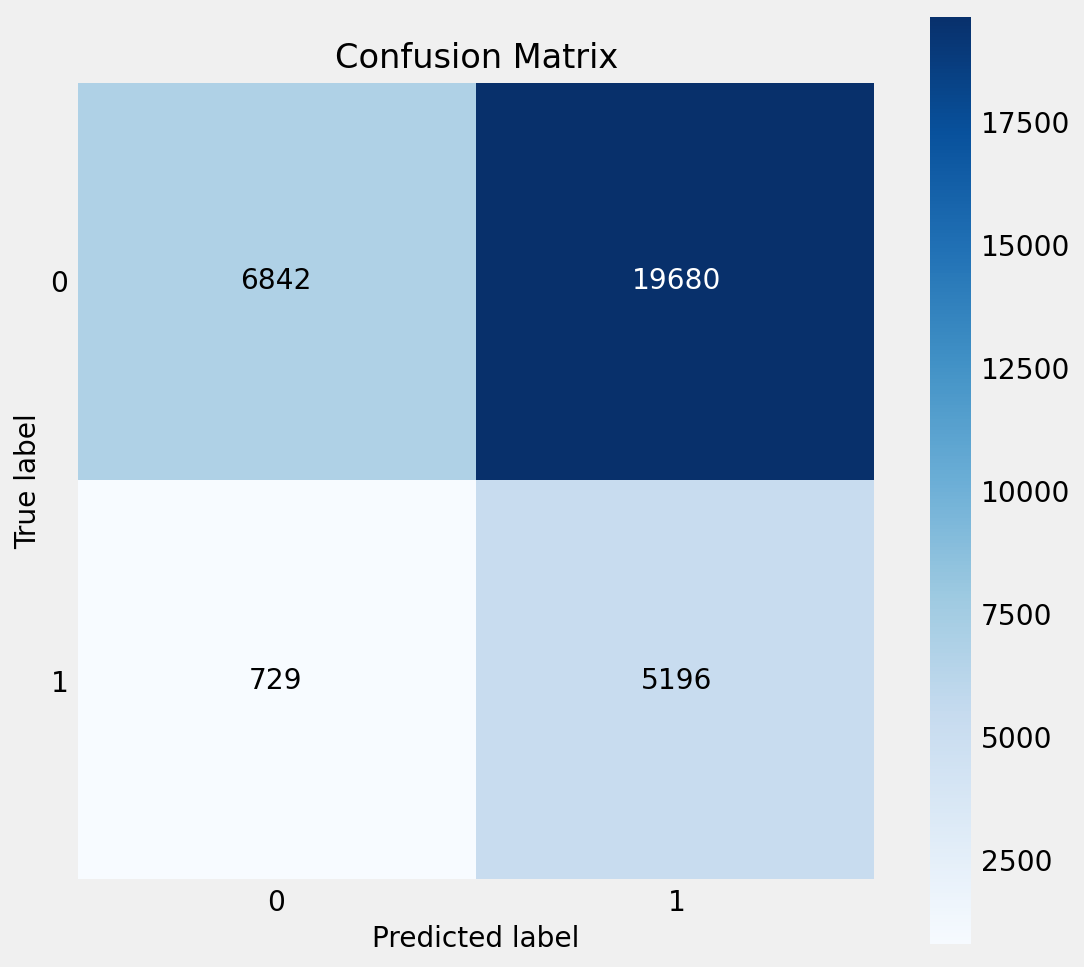

In [11]:
#creating a plot of the confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, dt_predictions, figsize=(8, 8))
plt.show()

In [12]:
#calculating the probabilities using the test set
dt_probabilities = pipe_dt_gs.predict_proba(X_test)

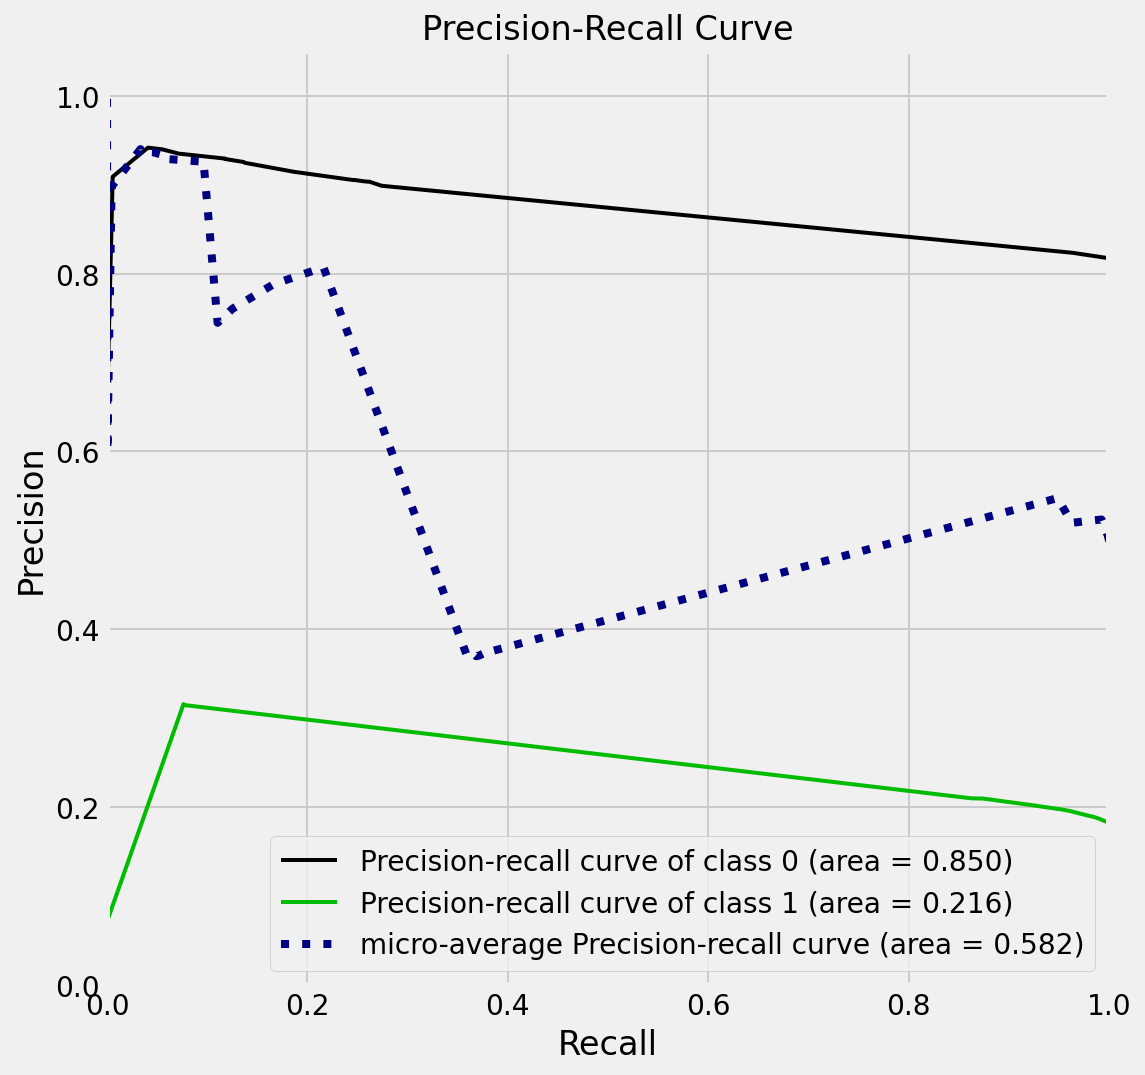

In [13]:
#plotting the precision-recall curve
skplt.metrics.plot_precision_recall(y_test, dt_probabilities, figsize=(8, 8))
plt.show()

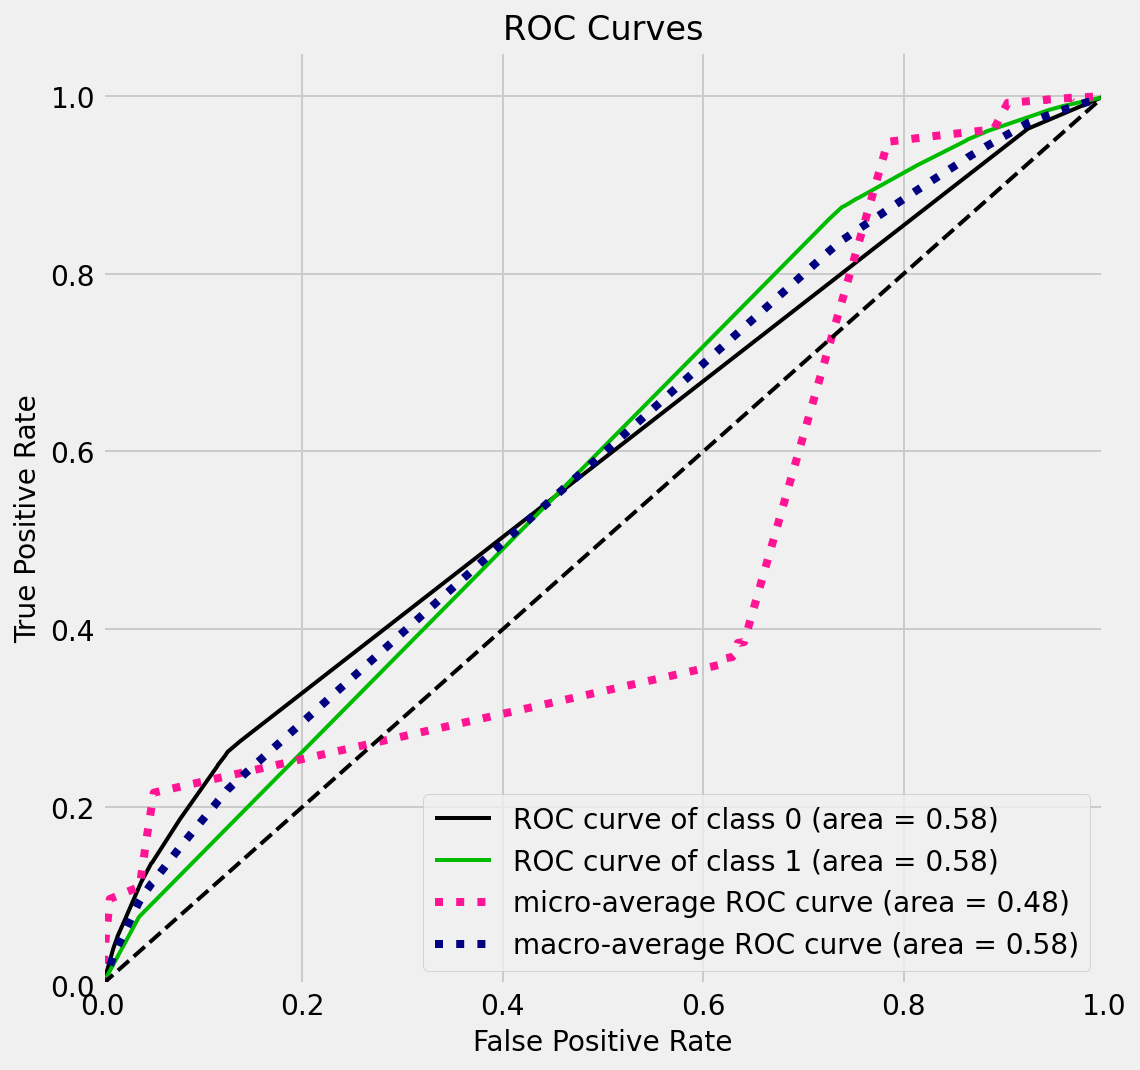

In [14]:
#plotting the ROC curve
skplt.metrics.plot_roc(y_test, dt_probabilities, figsize=(8, 8))
plt.show()

#### KNeighborsClassifier

In [15]:
#setting up a pipelie to account for the present imbalance in the target variable before fitting the model
pipe_knn = make_pipeline(RandomOverSampler(random_state=1),
                        (KNeighborsClassifier()))

#defining the possible values for hyper-parameter optimisation
pipe_knn_params = {'kneighborsclassifier__n_neighbors': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55],
                   'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'cosine'],
                   'kneighborsclassifier__weights': ['uniform', 'distance']}

#instantiating a GridSearchCV to carry out the optimisation
pipe_knn_gs = GridSearchCV(pipe_knn, pipe_knn_params, cv=5, n_jobs=-3, verbose=1, scoring='recall')
pipe_knn_gs.fit(X_train, y_train)

#printing out the cross-validated score
print('Mean cross-validated score:', pipe_knn_gs.best_score_)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Mean cross-validated score: 0.5443105753906465


In [16]:
#saving the model to file for future use
jl.dump(pipe_knn_gs, 'KNeighborsClassifier.jlib')

['KNeighborsClassifier.jlib']

In [17]:
#printing out the optimised hyper-parameters
pipe_knn_gs.best_params_

{'kneighborsclassifier__metric': 'cosine',
 'kneighborsclassifier__n_neighbors': 55,
 'kneighborsclassifier__weights': 'uniform'}

In [18]:
#making predictions on the test set
knn_predictions = pipe_knn_gs.predict(X_test)

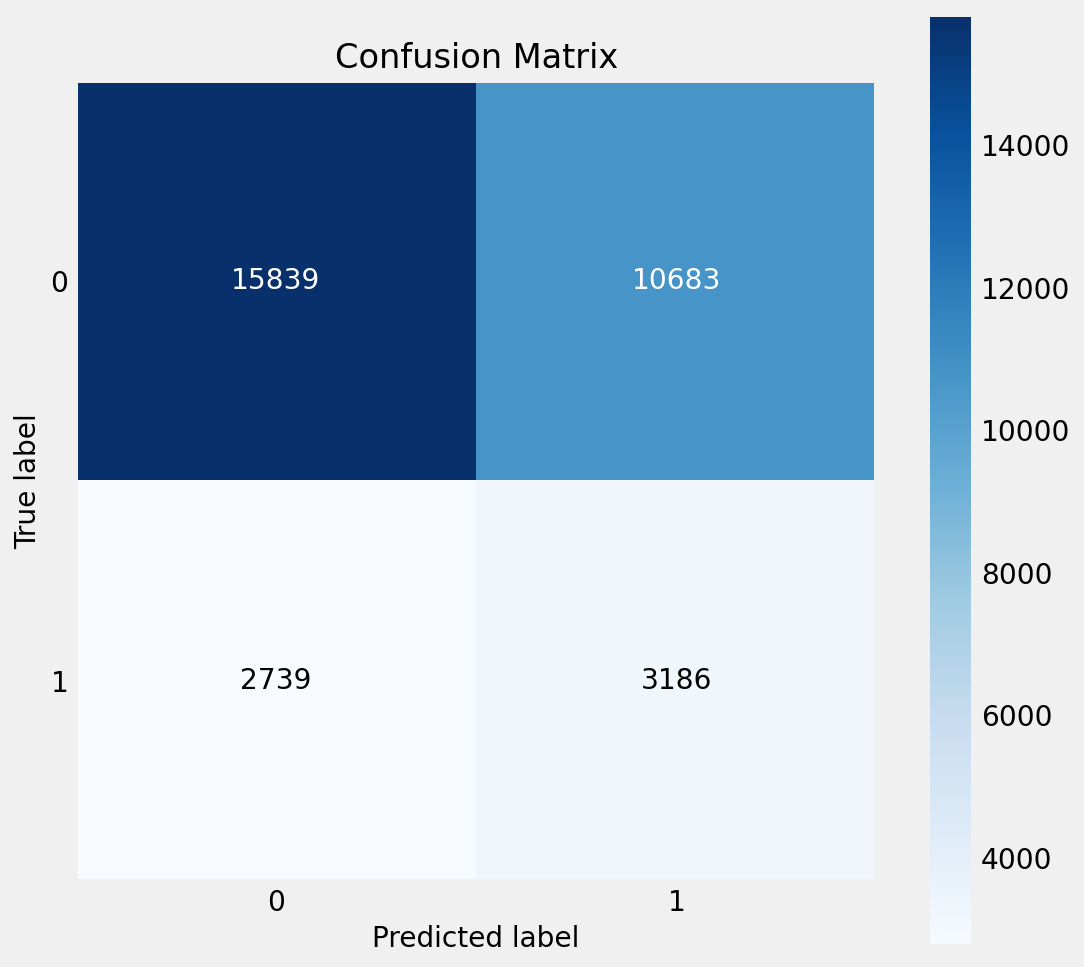

In [19]:
#creating a plot of the confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, knn_predictions, figsize=(8, 8))
plt.show()

In [20]:
#calculating the probabilities using the test set
knn_probabilities = pipe_knn_gs.predict_proba(X_test)

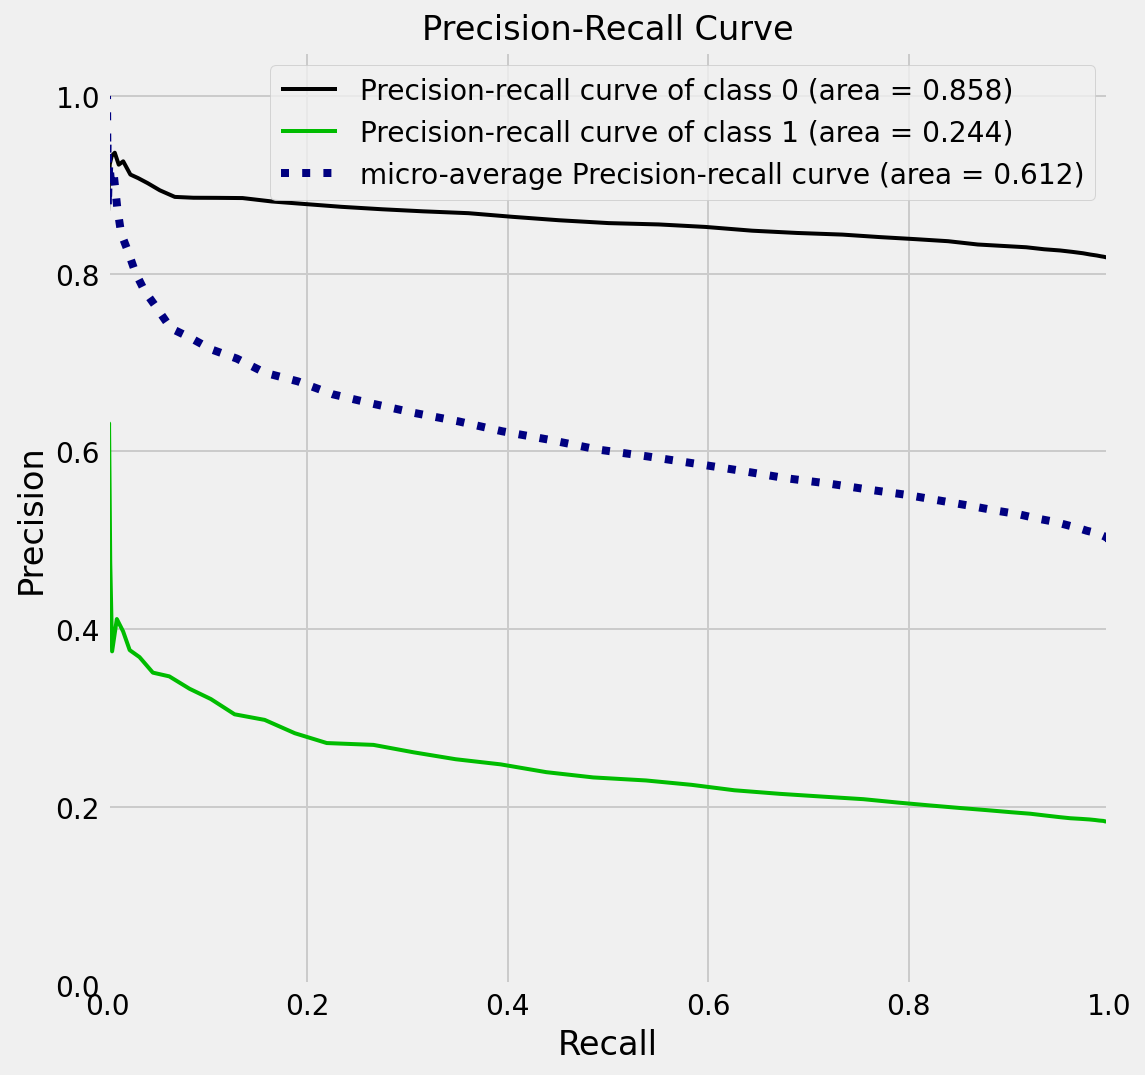

In [21]:
#plotting the precision-recall curve
skplt.metrics.plot_precision_recall(y_test, knn_probabilities, figsize=(8, 8))
plt.show()

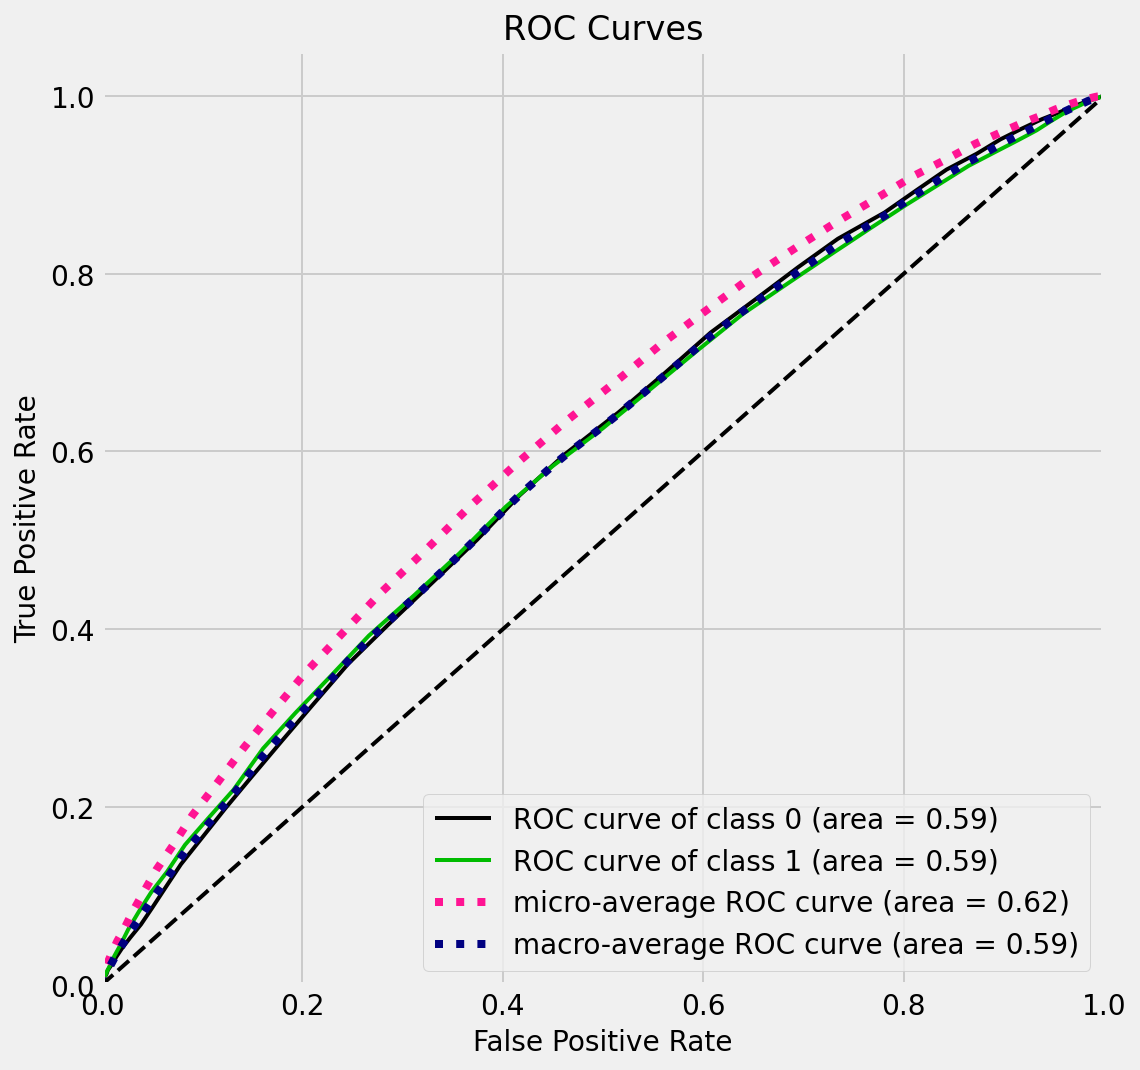

In [22]:
#plotting the ROC curve
skplt.metrics.plot_roc(y_test, knn_probabilities, figsize=(8, 8))
plt.show()

Looking at the above metrics, we can see that neither model performs to a high standard. However, given the nature of the available data, this isn't unexpected.

<code>DecisionTreeClassifier</code> achieves a very high recall score for class 1, but does this at the expense of precision, classifying a large majority of on-time flights as delayed. It's overall accuracy score is 0.582.

<code>KNeighborsClassifier</code> doesn't perform as well when based on recall score for class 1, but it also delivers a more respectable precision score for this class. It achieves an overall accuracy score of 0.612.

Given this outcome, it is clear that no single model can achieve a satisfactory outcome on it's own. Therefore, I decided to combine different models in a <code>VotingClassifier</code>, hoping that the sum of their strengths could yield better results. To do this, a <code>LogisticRegression</code> and a <code>GaussianNB</code> instance was added to the previously tried classifiers.

#### VotingClassifier

In [23]:
#instantiating the base estimators
dt = DecisionTreeClassifier(random_state=1)
knn = KNeighborsClassifier()
lr = LogisticRegression(max_iter=10000)
nb = GaussianNB()

In [24]:
#setting up a pipelie to account for the present imbalance in the target variable before fitting the model
pipe_vc = make_pipeline(RandomOverSampler(random_state=1),
                        VotingClassifier([('dt', dt), ('knn', knn), ('lr', lr), ('nb', nb)]))

In [25]:
#defining the possible values for hyper-parameter optimisation
pipe_vc_params = {'votingclassifier__voting': ['soft', 'hard'],
                  'votingclassifier__dt__criterion': ['gini', 'entropy'],
                  'votingclassifier__dt__max_features': [0.3, 0.6],
                  'votingclassifier__knn__metric': ['manhattan', 'euclidean', 'cosine'],
                  'votingclassifier__knn__n_neighbors': [35, 45, 55],
                  'votingclassifier__knn__weights': ['uniform', 'distance'],
                  'votingclassifier__lr__C': [0.05, 0.1, 0.2],
                  'votingclassifier__lr__fit_intercept': [True, False]}

#instantiating a GridSearchCV to carry out the optimisation
pipe_vc_gs = GridSearchCV(pipe_vc, pipe_vc_params, cv=5, n_jobs=-3, verbose=1, scoring='recall')
pipe_vc_gs.fit(X_train, y_train)

#printing out the cross-validated and test scores
print('Mean cross-validated score:', pipe_vc_gs.best_score_)
print('Test score:', pipe_vc_gs.score(X_test, y_test))

Fitting 5 folds for each of 864 candidates, totalling 4320 fits
Mean cross-validated score: 0.5366516017093972
Test score: 0.47459915611814346


In [26]:
#saving the model to file for future use
jl.dump(pipe_vc_gs, 'VotingClassifier.jlib')

['VotingClassifier.jlib']

In [27]:
#printing out the optimised hyper-parameters
pipe_vc_gs.best_params_

{'votingclassifier__dt__criterion': 'gini',
 'votingclassifier__dt__max_features': 0.6,
 'votingclassifier__knn__metric': 'cosine',
 'votingclassifier__knn__n_neighbors': 55,
 'votingclassifier__knn__weights': 'uniform',
 'votingclassifier__lr__C': 0.05,
 'votingclassifier__lr__fit_intercept': False,
 'votingclassifier__voting': 'soft'}

In [28]:
#making predictions on the test set
vc_predictions = pipe_vc_gs.predict(X_test)

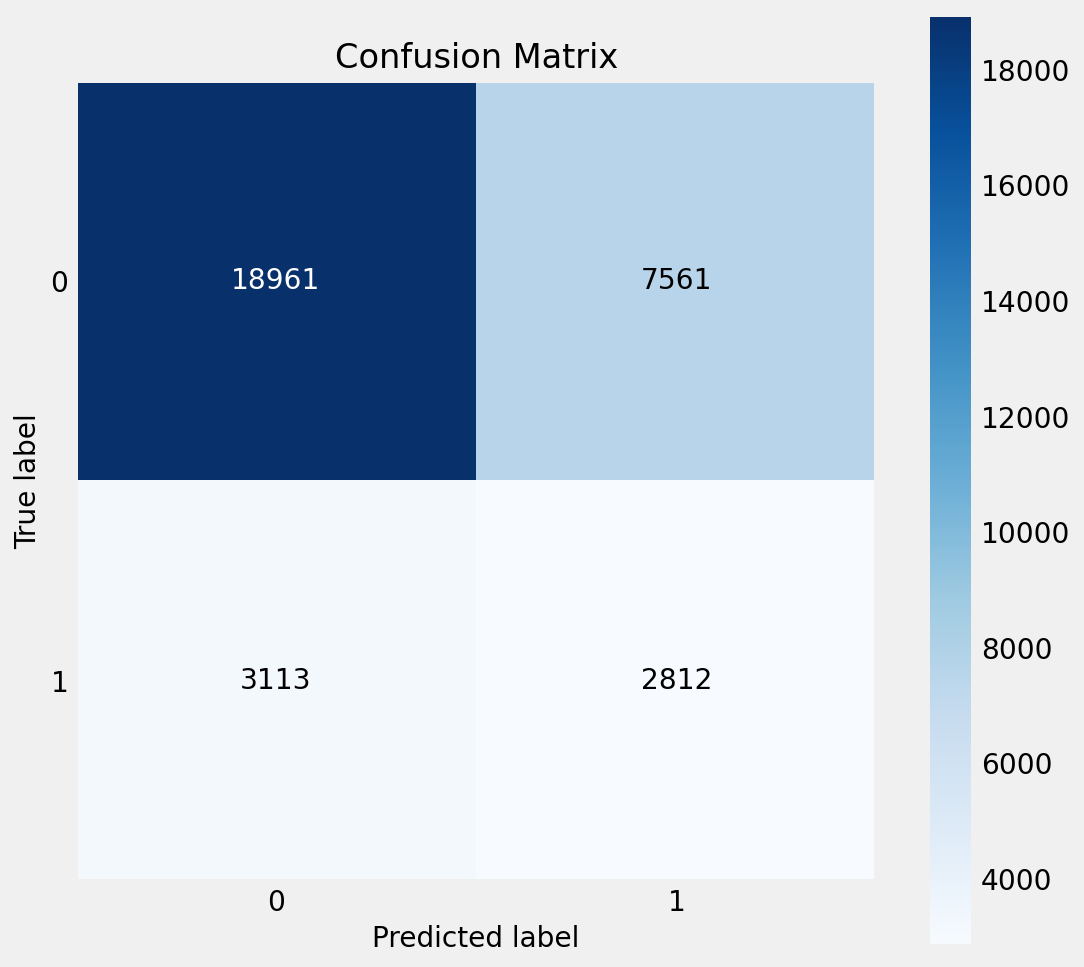

In [29]:
#creating a plot of the confusion matrix
skplt.metrics.plot_confusion_matrix(y_test, vc_predictions, figsize=(8, 8))
plt.show()

In [30]:
#calculating the probabilities using the test set
vc_probabilities = pipe_vc_gs.predict_proba(X_test)

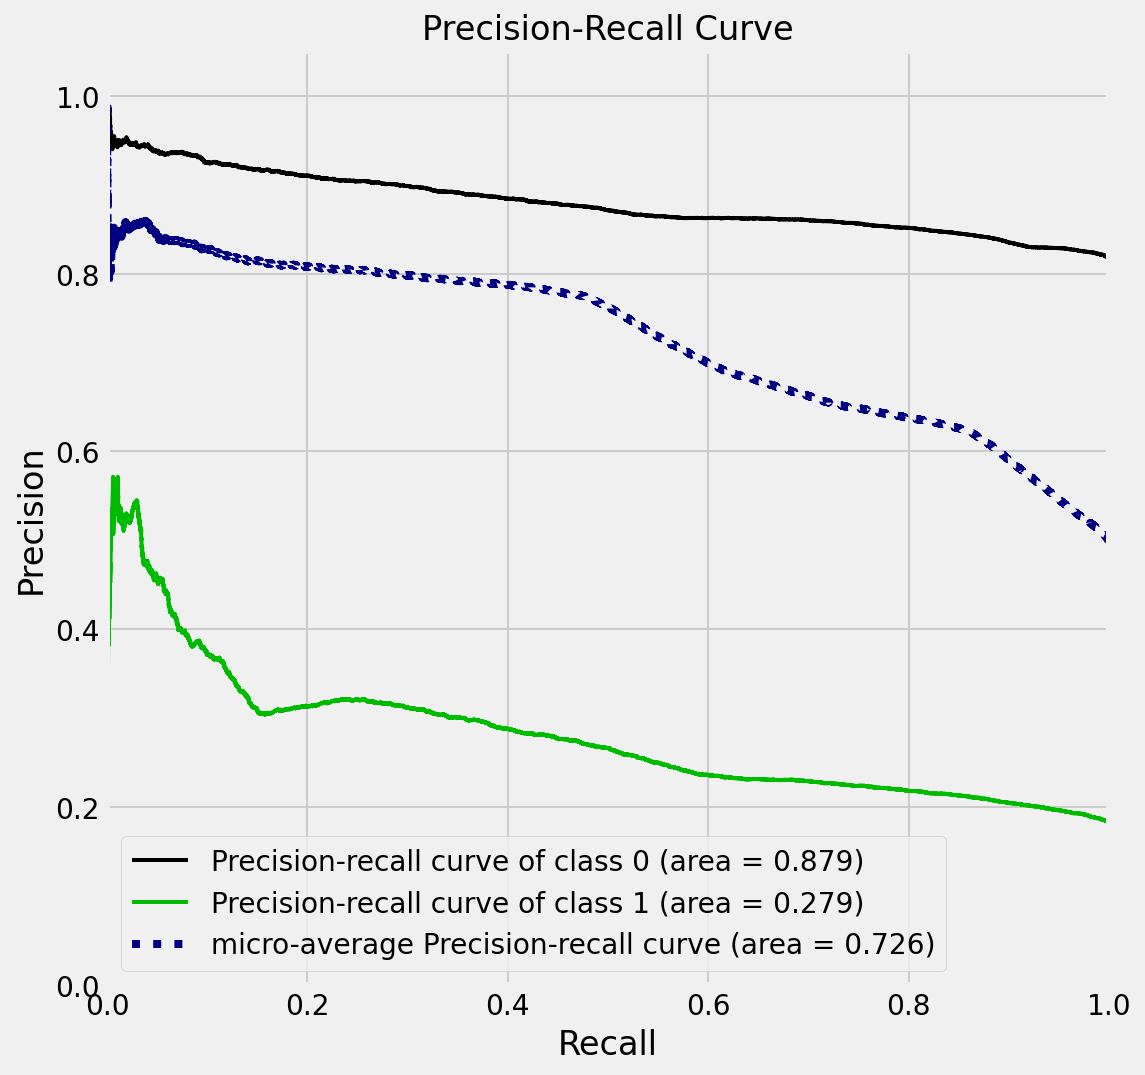

In [31]:
#plotting the precision-recall curve
skplt.metrics.plot_precision_recall(y_test, vc_probabilities, figsize=(8, 8))
plt.show()

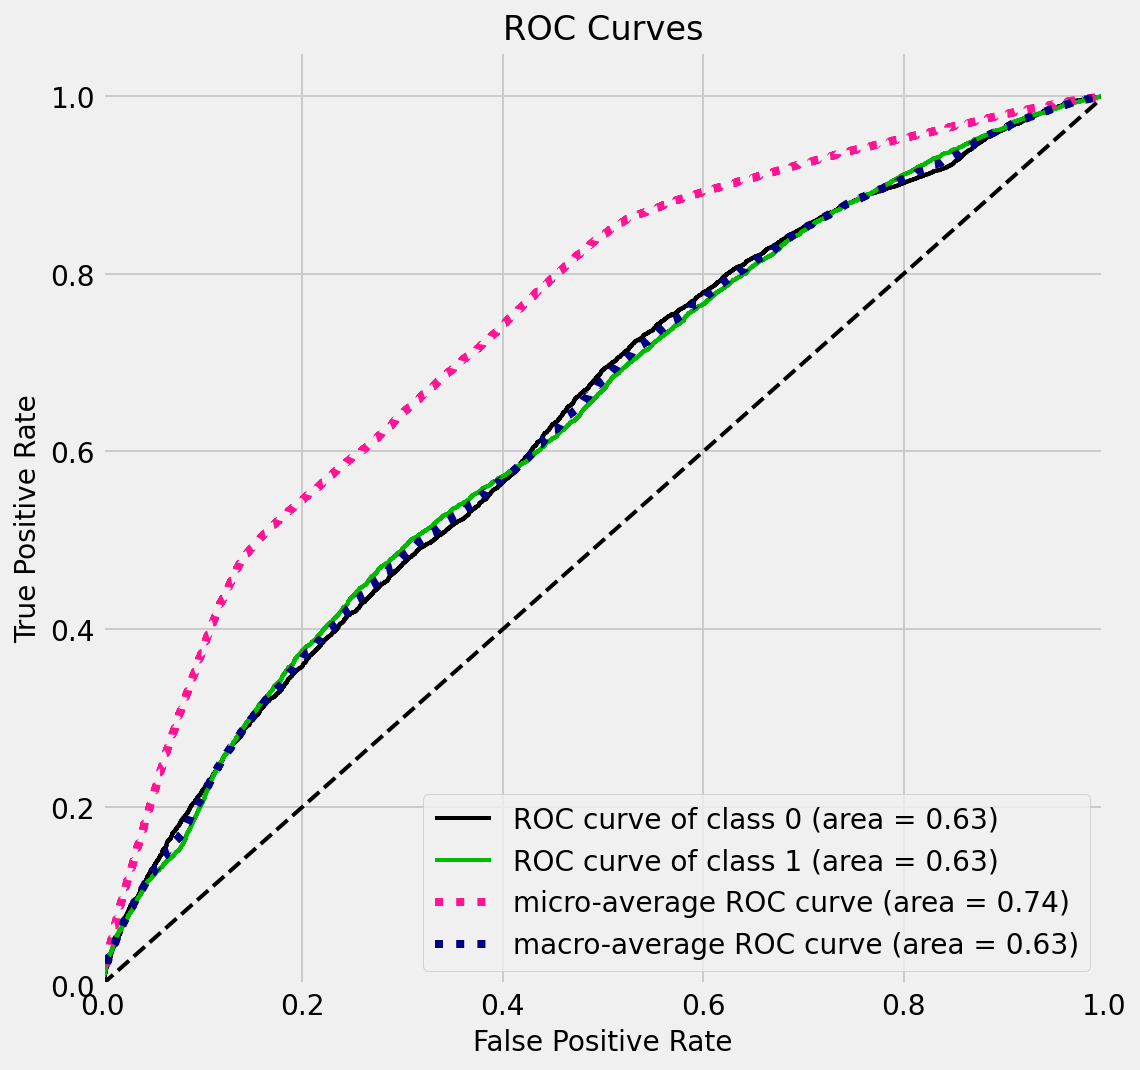

In [32]:
#plotting the ROC curve
skplt.metrics.plot_roc(y_test, vc_probabilities, figsize=(8, 8))
plt.show()

Using an ensemble method clearly improves performance, achieving an accuracy score higher than any single model previously tried: 0.726. While this model offers the best compromise between recall and precision scores, it has a major downside: low interpretability. This means it's not possible to assign importance to each feature when it comes to deciding which predictors have the most influence on flight delay. But, if our aim is to simply predict which flight is delayed and which flight isn't, this model offers the best compromise.